Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

Loading  and cleaning data

In [2]:
DATA_PATH = "Consumption Dataset - Dataset.csv"

df = pd.read_csv(DATA_PATH)

df.columns = df.columns.str.lower()

print("Columns found:", df.columns.tolist())


DATE_COL = "date time served"
ITEM_COL = "brand name"
LOCATION_COL = "bar name"
QTY_COL = "consumed (ml)"


df[DATE_COL] = pd.to_datetime(df[DATE_COL])

df = df[[DATE_COL, ITEM_COL, LOCATION_COL, QTY_COL]]

df = df.rename(columns={
    DATE_COL: "date",
    ITEM_COL: "item_id",
    LOCATION_COL: "location_id",
    QTY_COL: "quantity"
})

# aggregate daily demand
df["date"] = df["date"].dt.date

df = (
    df.groupby(["date","item_id","location_id"])["quantity"]
    .sum()
    .reset_index()
)

df["date"] = pd.to_datetime(df["date"])

print(df.head())
print("Shape:", df.shape)


Columns found: ['date time served', 'bar name', 'alcohol type', 'brand name', 'opening balance (ml)', 'purchase (ml)', 'consumed (ml)', 'closing balance (ml)']
        date         item_id     location_id  quantity
0 2023-01-01         Absolut    Taylor's Bar       0.0
1 2023-01-01         Bacardi  Anderson's Bar       0.0
2 2023-01-01  Captain Morgan     Brown's Bar       0.0
3 2023-01-01  Captain Morgan     Smith's Bar       0.0
4 2023-01-01           Coors   Johnson's Bar       0.0
Shape: (6575, 4)


In [3]:
ML_PER_BOTTLE = 750

df["quantity"] = df["quantity"] / ML_PER_BOTTLE


Exploratory Analysis

We inspect:
total daily demand trend, number of items, number of locations

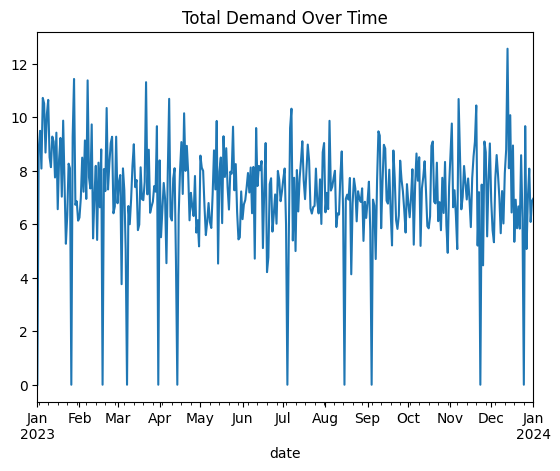

Items: 16
Locations: 6


In [4]:
daily_total = df.groupby("date")["quantity"].sum()

daily_total.plot(title="Total Demand Over Time")
plt.show()

print("Items:", df["item_id"].nunique())
print("Locations:", df["location_id"].nunique())


Feature Engineering

We add weekday, month, weekend flag, lag demand, rolling averages
These help capture seasonality and trends.

In [5]:
def create_features(d):

    d = d.copy()

    d["dow"] = d["date"].dt.dayofweek
    d["month"] = d["date"].dt.month
    d["week"] = d["date"].dt.isocalendar().week.astype(int)
    d["is_weekend"] = (d["dow"] >= 5).astype(int)

    for lag in [1,2,7,14]:
        d[f"lag_{lag}"] = d.groupby(
            ["item_id","location_id"]
        )["quantity"].shift(lag)

    d["rolling_mean_7"] = d.groupby(
        ["item_id","location_id"]
    )["quantity"].shift(1).rolling(7).mean()

    d["rolling_std_7"] = d.groupby(
        ["item_id","location_id"]
    )["quantity"].shift(1).rolling(7).std()

    return d


df = create_features(df)

df = df.dropna()

df.head()


,date,item_id,location_id,quantity,dow,month,week,is_weekend,lag_1,lag_2,lag_7,lag_14,rolling_mean_7,rolling_std_7
768,2023-02-10,Jack Daniels,Brown's Bar,0.728653,4,2,6,0,0.710613,0.478413,0.371080,0.267987,0.427478,0.249305
791,2023-02-12,Absolut,Taylor's Bar,0.199467,6,2,6,1,0.664893,0.311973,0.209893,0.000000,0.481088,0.403079
809,2023-02-13,Absolut,Taylor's Bar,0.693493,0,2,7,0,0.199467,0.664893,0.411520,0.711413,0.478514,0.228110
845,2023-02-15,Absolut,Taylor's Bar,0.425867,2,2,7,0,0.693493,0.199467,0.623760,0.359573,0.435718,0.262665
896,2023-02-17,Smirnoff,Smith's Bar,0.040720,4,2,7,0,0.582120,0.174387,0.320760,0.251440,0.340290,0.219996


Train Test Split

We forecast the last 30 days to simulate real deployment.

In [6]:
split_date = df["date"].max() - pd.Timedelta(days=30)

train = df[df["date"] <= split_date]
test  = df[df["date"] > split_date]

features = [
    "dow","month","week","is_weekend",
    "lag_1","lag_2","lag_7","lag_14",
    "rolling_mean_7","rolling_std_7"
]

X_train, y_train = train[features], train["quantity"]
X_test, y_test = test[features], test["quantity"]


Forecasting Model

We use LightGBM becauseof its strong performance on tabular data,  handles non-linear patterns,  fast training scalable to many items

In [7]:
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
preds = np.maximum(preds, 0)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 4700, number of used features: 10
[LightGBM] [Info] Start training from score 0.396320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

MAE: 0.21
RMSE: 0.26
MAPE: 15.3 %


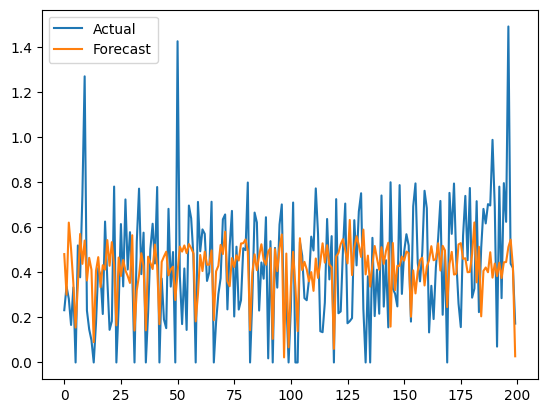

In [8]:
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = np.mean(np.abs((y_test - preds)/(y_test+1))) * 100

print("MAE:", round(mae,2))
print("RMSE:", round(rmse,2))
print("MAPE:", round(mape,2), "%")

plt.plot(y_test.values[:200], label="Actual")
plt.plot(preds[:200], label="Forecast")
plt.legend()
plt.show()


Par Level Calculation

Par Level = demand × lead time + safety stock
Safety stock protects against demand uncertainty.


In [ ]:
LEAD_TIME = 2
SERVICE_LEVEL_Z = 1.65

test["forecast"] = preds

stats = test.groupby(["item_id","location_id"]).agg(
    mean_demand=("forecast","mean"),
    std_demand=("forecast","std")
).reset_index()

stats["par_level"] = (
    stats["mean_demand"] * LEAD_TIME +
    SERVICE_LEVEL_Z * stats["std_demand"] * np.sqrt(LEAD_TIME)
)

stats.head()


C:\Users\ncfad\AppData\Local\Temp\ipykernel_8824\2264500088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["forecast"] = preds


,item_id,location_id,mean_demand,std_demand,par_level
0,Absolut,Anderson's Bar,0.475350,0.075450,1.126758
1,Absolut,Brown's Bar,0.417196,0.107199,1.084535
2,Absolut,Johnson's Bar,0.475544,0.107480,1.201887
3,Absolut,Smith's Bar,0.406853,0.023588,0.868748
4,Absolut,Taylor's Bar,0.451494,0.107819,1.154578


Inventory Simulation

We simulate daily consumption, restocking, holding cost, stockout cost


In [10]:
HOLDING_COST = 1
STOCKOUT_COST = 5

results_list = []

for (item, location), group in test.groupby(["item_id","location_id"]):

    group = group.sort_values("date")

    par = stats.loc[
        (stats["item_id"]==item) &
        (stats["location_id"]==location),
        "par_level"
    ].values[0]

    inventory = par

    holding = 0
    stockout = 0
    stockouts = 0

    for demand in group["quantity"]:

        inventory -= demand

        if inventory < 0:
            stockouts += 1
            stockout += abs(inventory) * STOCKOUT_COST
            inventory = 0

        holding += inventory * HOLDING_COST

        if inventory < par * 0.3:
            inventory = par

    results_list.append([
        item, location, holding, stockout, stockouts
    ])


results = pd.DataFrame(
    results_list,
    columns=["item_id","location_id","holding_cost","stockout_cost","stockouts"]
)

results["total_cost"] = results["holding_cost"] + results["stockout_cost"]

results.head()


,item_id,location_id,holding_cost,stockout_cost,stockouts,total_cost
0,Absolut,Anderson's Bar,3.157136,0.930610,1,4.087747
1,Absolut,Brown's Bar,2.296810,0.000000,0,2.296810
2,Absolut,Johnson's Bar,2.874155,0.000000,0,2.874155
3,Absolut,Smith's Bar,1.535766,0.692926,1,2.228692
4,Absolut,Taylor's Bar,2.081766,0.000000,0,2.081766


Business KPIs

In [11]:
print("Total Holding Cost:", results["holding_cost"].sum())
print("Total Stockout Cost:", results["stockout_cost"].sum())
print("Total Cost:", results["total_cost"].sum())
print("Stockouts:", results["stockouts"].sum())

Total Holding Cost: 236.1502714472046
Total Stockout Cost: 70.30715868833492
Total Cost: 306.4574301355395
Stockouts: 73


Exporting needy

In [12]:
recommendations = stats[["item_id","location_id","par_level"]]

recommendations.to_csv("inventory_recommendations.csv", index=False)

print("Saved inventory_recommendations.csv")


Saved inventory_recommendations.csv
